In [137]:
import pandas as pd
import numpy as np

In [53]:
# fixed seed
np.random.seed(42)

# days of data
num_days = 30
base_date = pd.Timestamp('2024-01-01')
dates = [base_date + pd.Timedelta(days=i) for i in range(num_days)]

# create a dataframe
data = {
    'date': dates,
    'dayofweek': [d.strftime('%A') for d in dates],
}

# the numbers of order in the morning hours
hour_means = [150, 160, 170, 180]
for i, h in enumerate(range(8, 12)):
    data[f'hour_{h}'] = np.random.poisson(lam=hour_means[i], size=num_days)

# generate a total orders
df = pd.DataFrame(data)
df['total_orders'] =  df[[f'hour_{h}' for h in range(8, 12)]].sum(axis=1) + np.random.randint(500, 1200, size=num_days)

# classifiy trends based on the previous day: up or down if the change is +-10% or more, otherwise flat
df['order_trend'] = 'flat'
for i in range(1, len(df)):
    prev = df.loc[i-1, 'total_orders']
    curr = df.loc[i, 'total_orders']
    change_ratio = (curr - prev) / prev
    if change_ratio >= 0.1:
        df.loc[i, 'order_trend'] = 'up'
    elif change_ratio <= -0.1:
        df.loc[i, 'order_trend'] = 'down'

In [138]:
df = pd.read_csv('fake_pizza_orders_extended.csv')

In [139]:
df.head()

,date,hour,orders,backlog,shipping_plan
0,2024-05-01,8,70,4,70
1,2024-05-01,9,66,5,68
2,2024-05-01,10,64,0,60
3,2024-05-01,11,62,0,59
4,2024-05-01,12,74,0,73


In [140]:
df['date'] = pd.to_datetime(df['date'])


In [124]:
df.dtypes

date             datetime64[ns]
hour                      int64
orders                    int64
backlog                   int64
shipping_plan             int64
dtype: object

In [141]:
# Assuming 'date' is a column in your DataFrame
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.day_name()

# Drop the original 'date' column if it's not needed
#df = df.drop(columns=['date'])

In [142]:
# Assuming 'dayofweek' is a column in your DataFrame
df = pd.get_dummies(df, columns=['dayofweek'])

# Now, 'dayofweek' will be replaced with columns like 'dayofweek_Monday', 'dayofweek_Tuesday', etc.

In [143]:
df.head()

,date,hour,orders,backlog,shipping_plan,year,month,day,dayofweek_Friday,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday
0,2024-05-01,8,70,4,70,2024,5,1,False,False,False,False,False,False,True
1,2024-05-01,9,66,5,68,2024,5,1,False,False,False,False,False,False,True
2,2024-05-01,10,64,0,60,2024,5,1,False,False,False,False,False,False,True
3,2024-05-01,11,62,0,59,2024,5,1,False,False,False,False,False,False,True
4,2024-05-01,12,74,0,73,2024,5,1,False,False,False,False,False,False,True


In [56]:
#trend_mapping = {'up': 1, 'down': -1, 'flat': 0}
#df['order_trend_numeric'] = df['order_trend'].map(trend_mapping)

In [144]:
# 日単位で注文数を合計
daily_total = df.groupby("date")["orders"].sum().reset_index()
daily_total.rename(columns={"orders": "daily_orders"}, inplace=True)

# 注文トレンド（前日比）を計算
daily_total["order_trend"] = daily_total["daily_orders"].diff().apply(
    lambda x: 1 if x > 0 else (-1 if x < 0 else 0)
)

# 元データに結合（各時間行に同じトレンドを持たせる）
df = df.merge(daily_total[["date", 'daily_orders', "order_trend"]], on="date", how="left")


In [57]:
#df_long = df.melt(
    id_vars=['date'], 
    value_vars=['hour_8', 'hour_9', 'hour_10', 'hour_11'],
    var_name='hour',
    value_name='orders'
)

# hour列を「数字の時間」に変換（例: 'hour_8' → 8）
#df_long['hour'] = df_long['hour'].str.extract('(\d+)').astype(int)

# 累積列を作る
#df_long['cumulative_orders'] = df_long.groupby('date')['orders'].cumsum()

# 並び替え（見やすく）
#df_long = df_long.sort_values(['date', 'hour']).reset_index(drop=True)


In [58]:
# 元の df から date と total_orders だけを抜き出す
#df_total = df[['date', 'total_orders']]

# long形式のデータと結合（dateキーで）
#df_long = df_long.merge(df_total, on='date', how='left')


In [59]:
# 必要なカラムを含めたDataFrameを作成
#df_meta = df[['date', 'total_orders', 'order_trend', 'order_trend_numeric','year', 'month', 'day','dayofweek_Friday', 'dayofweek_Monday', 'dayofweek_Saturday','dayofweek_Sunday', 'dayofweek_Thursday', 'dayofweek_Tuesday', 'dayofweek_Wednesday']]

# df_long に結合（date列をキーに）
#df_long = df_long.merge(df_meta, on='date', how='left')


In [61]:
# total_orders_x は削除、total_orders_y を total_orders にリネーム
#df_long = df_long.drop(columns=['total_orders_x'])
#df_long = df_long.rename(columns={'total_orders_y': 'total_orders'})


In [154]:
df['is_weekend'] = df['dayofweek_Saturday'] | df['dayofweek_Sunday']

# 日付ごとに、時間順に並べて累積注文数を計算
df["cumulative_orders"] = df.sort_values(["date", "hour"]).groupby("date")["orders"].cumsum()

In [155]:
df.head()

,date,hour,orders,backlog,shipping_plan,year,month,day,dayofweek_Friday,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,daily_orders,order_trend,is_weekend,cumulative_orders
0,2024-05-01,8,70,4,70,2024,5,1,False,False,False,False,False,False,True,720,0,False,70
1,2024-05-01,9,66,5,68,2024,5,1,False,False,False,False,False,False,True,720,0,False,136
2,2024-05-01,10,64,0,60,2024,5,1,False,False,False,False,False,False,True,720,0,False,200
3,2024-05-01,11,62,0,59,2024,5,1,False,False,False,False,False,False,True,720,0,False,262
4,2024-05-01,12,74,0,73,2024,5,1,False,False,False,False,False,False,True,720,0,False,336


In [147]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pylab as plt

In [156]:
# define the feature and object variables
X = df[['hour', 'orders', 'cumulative_orders', 'year', 'month', 'day', 'order_trend', 	
    'dayofweek_Friday', 'dayofweek_Monday', 'dayofweek_Saturday', 'dayofweek_Sunday', 'dayofweek_Thursday', 'dayofweek_Tuesday', 'dayofweek_Wednesday','is_weekend']]
y = df['daily_orders']

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [157]:
# model definition and training
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [158]:
# predict 
y_pred = model.predict(X_test)

#evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

MAE: 14.25
RMSE: 18.15


In [159]:
print(y_pred)

[560.16331653 565.47855859 715.05484218 770.82123651 710.36494452
 723.81977013 499.50820388 521.77290116 751.04350609 762.22959376
 773.35880802 513.24465498 778.18140602 752.76919578 707.7055851
 785.54774912 753.55563414 707.11051952 757.03651252 741.59324901
 776.123224   759.01783705 740.84583038 538.54278699 538.69405233
 731.78912591 751.02491838 761.53652871 698.65571303 558.75789977
 753.69178708 731.15159749 556.32600665 720.27224159 546.37234089
 762.9155968  533.81474112 747.19760426 713.27451402 722.60369709
 772.04028473 743.39262187]


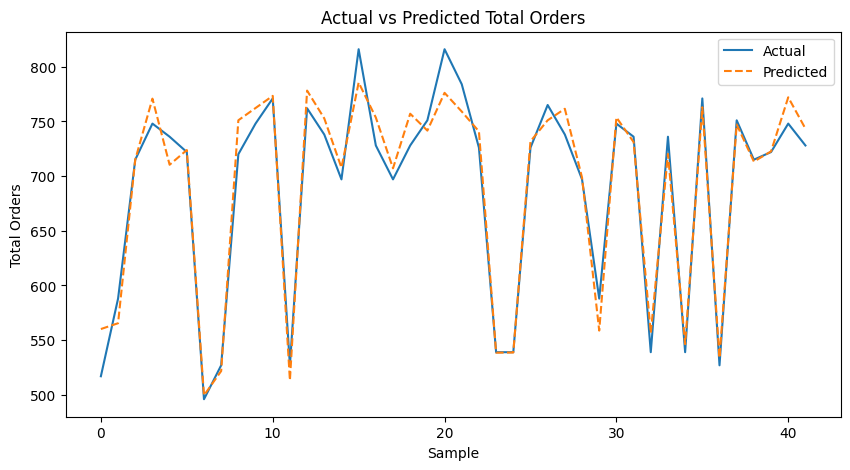

In [160]:
# plot
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.legend()
plt.title('Actual vs Predicted Total Orders')
plt.xlabel('Sample')
plt.ylabel('Total Orders')
plt.show()

In [70]:
import lightgbm as lgb

In [161]:
# object variable 
target = 'daily_orders'

# explanatory variable
features = [
    'hour', 'orders', 'cumulative_orders', 'year', 'month', 'day', 'order_trend', 	
    'dayofweek_Friday', 'dayofweek_Monday', 'dayofweek_Saturday', 'dayofweek_Sunday', 
    'dayofweek_Thursday', 'dayofweek_Tuesday', 'dayofweek_Wednesday','is_weekend'
]

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

params = {
    'objective': 'regression',
    'metric': 'mae',
    'learnig_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1,
    'early_stopping_round': 10
}

In [162]:
model = lgb.train(params, train_data, valid_sets=[test_data])

y_pred = model.predict(X_test)

In [163]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

MAE: 2.32
RMSE: 2.92


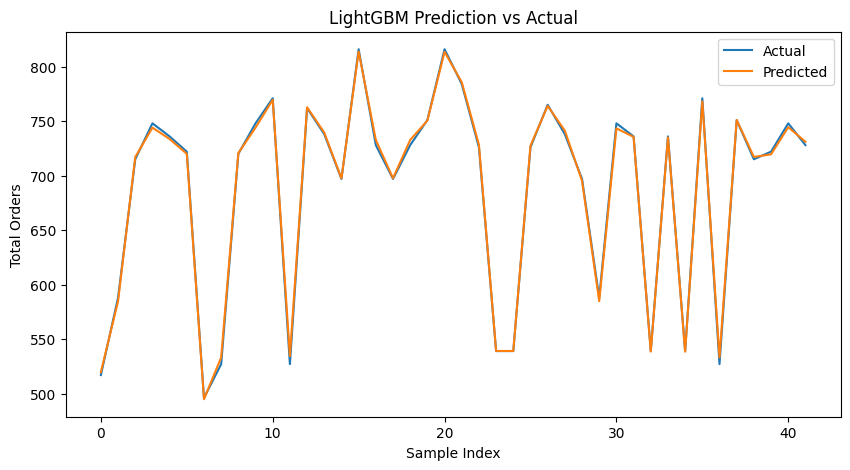

In [164]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('LightGBM Prediction vs Actual')
plt.xlabel('Sample Index')
plt.ylabel('Total Orders')
plt.show()

                Feature  Importance
5                   day         283
6           order_trend          65
14           is_weekend          44
1                orders          43
11   dayofweek_Thursday          26
10     dayofweek_Sunday          25
7      dayofweek_Friday          23
2     cumulative_orders          16
8      dayofweek_Monday          15
9    dayofweek_Saturday          12
13  dayofweek_Wednesday           7
12    dayofweek_Tuesday           6
0                  hour           1
3                  year           0
4                 month           0


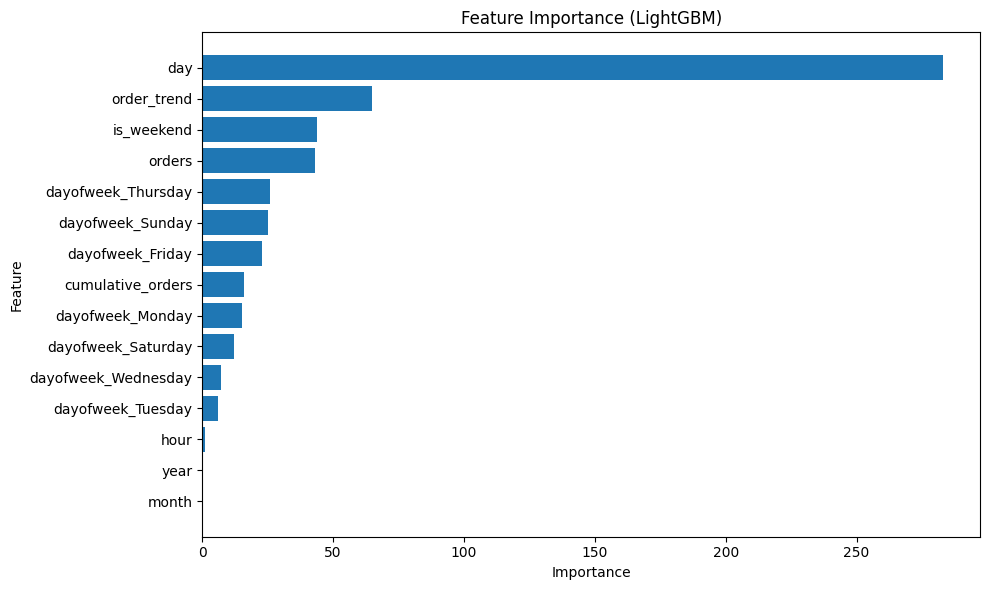

In [165]:
# 特徴量の重要度を取得
importance = model.feature_importance()
feature_names = X.columns

# DataFrameにまとめてソート
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# 表示
print(importance_df)

# グラフで可視化
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importance (LightGBM)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [166]:
import joblib
joblib.dump(model, "model1.pkl")

['model1.pkl']